In [1]:
from model import *
from function import *
from EKF import *
import numpy as np

In [2]:
Lat = 55.0 * (np.pi / 180.0)
Lon = 38.0 * (np.pi / 180.0)

Lat_old = Lat
Alt = 0
Alt_old = 0

# Вычисление силы тяжести

(X,Y,Z) = LatLonAlt2XYZ(Lat, Lon, Alt)
gravity = CalcGravity(X, Y, Z)
sinB = np.sin(Lat)
cosB = np.cos(Lat)
sinL = np.sin(Lon)
cosL = np.cos(Lon)

g_P_N_extrap = np.zeros(3)
g_P_N_extrap[0] = -cosL * sinB * gravity[0] - sinL * sinB * gravity[1] + cosB * gravity[2]
g_P_N_extrap[1] = cosL * cosB * gravity[0] + sinL * cosB * gravity[1] + sinB * gravity[2]
gt = abs(g_P_N_extrap[1])
U = 7.292115e-5

In [3]:
bias_gyro_x = (0.1 * np.pi / 180) / 3600.0 # рад / c
bias_gyro_y = (0.1 * np.pi / 180) / 3600.0 # рад / c
bias_gyro_z = (0.1 * np.pi / 180) / 3600.0 # рад / c
bias_acc_x = 0.02 * 1e-3 * gt
bias_acc_y = 0.02 * 1e-3 * gt
bias_acc_z = 0.02 * 1e-3 * gt
# вектора смещений
bias_gyro = np.array([bias_gyro_y, bias_gyro_z, bias_gyro_x],dtype = np.float64)
bias_acc = np.array([bias_acc_y, bias_acc_z, bias_acc_x],dtype = np.float64)
K_gyro = np.eye(3,dtype = np.float64)
K_acc = np.eye(3,dtype = np.float64)
# идеальные показания
acc = np.array([0.0, gt, 0.0], dtype = np.float64)
gyro = np.array([(U * np.cos(Lat)), (U * np.sin(Lat)), 0],dtype = np.float64)
# Синтезированные показания
acc = K_acc @ acc + bias_acc
gyro = K_gyro @ gyro + bias_gyro

In [4]:
Sensors = np.zeros((6,2),dtype = np.float64)
W_NUE = np.array([0,0,0])
W_NUE_old = np.array([0,0,0])
dt = 1.0 / 100.0
Roll = 1 * np.pi / 180
Pitch = 2 * np.pi / 180
Heading = 180.0 * np.pi / 180
C_B_N = DCM_bn(Heading, Pitch, Roll)
acc = C_B_N.T @ acc
gyro = C_B_N.T @ gyro
T = 60 * 90 # c
N = 100 * T
t = np.linspace(0,T,N)

NavState = np.array([Lat,Lon,Alt,          # Широта, долгота, геодезическая высота
                   W_NUE[0],W_NUE[1],W_NUE[2],               # Скорость на север, вверх, на восток
                   Roll,Pitch,Heading,   # Крен, тангаж, курс
                   0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,           # Ошибки масштабных коэффициентов акселерометров, смещения нуля акселерометров, ошибки масштабных коэффициентов гироскопов
                   Lat_old,Alt_old,              # Предыдущие широта и высота
                   W_NUE_old[0],W_NUE_old[1],W_NUE_old[2]])

In [5]:
queue_Lat = np.zeros(N)
queue_Lon = np.zeros(N)
queue_pitch = np.zeros(N)
queue_roll = np.zeros(N)
queue_heading = np.zeros(N)
queue_Alt = np.zeros(N)
queue_W_N = np.zeros(N)
queue_W_U = np.zeros(N)
queue_W_E = np.zeros(N)

In [6]:
Sensors[0:3,1] = acc * 1e-2 # выходной сигнал акселерометра по осям чувствительности (x,y,z) на текущем такте расчетов
Sensors[0:3,0] = acc * 1e-2
Sensors[3:6,0] = gyro * 1e-2
Sensors[3:6,1] = gyro * 1e-2

In [11]:
acc_enu = np.array([acc[2],acc[0],acc[1]])
acc_enu

array([-0.1713929 ,  0.34235335,  9.80784466])

In [ ]:
Q = np.diag([1,1,1,1,1,1,1,1])
R = np.diag([1,1])
P = np.diag([1,1,1,1,1,1,1,1])

In [7]:
for i in range(0,N):
    NavState[2] = 0.0
    NavState[4] = 0.0
    queue_Lat[i] = NavState[0]
    queue_Lon[i] = NavState[1]
    queue_roll[i] = NavState[6]
    queue_pitch[i] = NavState[7]
    queue_heading[i] = NavState[8]
    queue_W_N[i] = NavState[3]
    queue_W_U[i] = NavState[4]
    queue_W_E[i] = NavState[5]
    queue_Alt[i] = NavState[2]
    H = NavState[8]
    Lat = NavState[0]
    beta = 1 / 0.1
    A = 0.008
    F = create_F(gt,acc_enu,H, L, beta ,dt)
    G = create_G(A, beta, dt)
    
    (NavState, delta_v, delta_alpha, gt, C_B_N) = Savage(NavState, Sensors, dt, C_B_N)

In [8]:
queue_Lat = queue_Lat * (180.0 / np.pi)
queue_Lon = queue_Lon * (180.0 / np.pi)
queue_pitch = queue_pitch * (180.0 / np.pi)
queue_roll = queue_roll * (180.0 / np.pi)
queue_heading = queue_heading * (180.0 / np.pi)

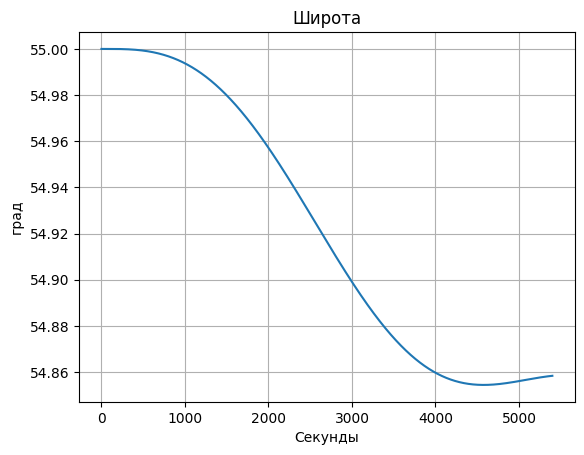

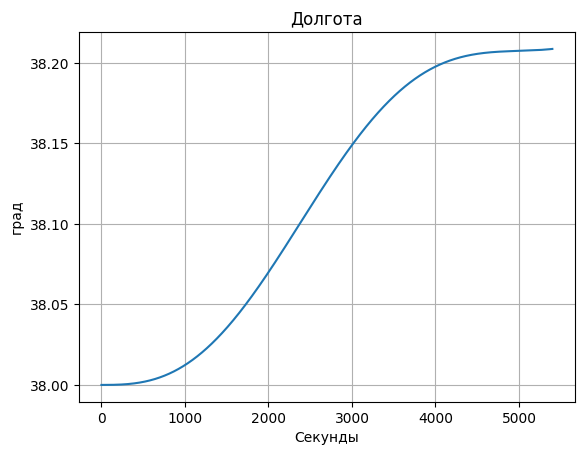

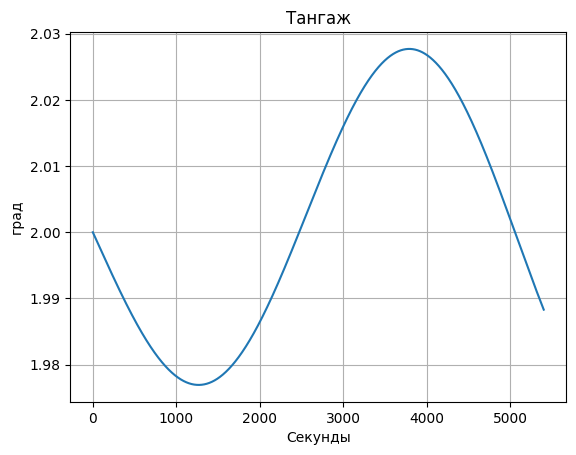

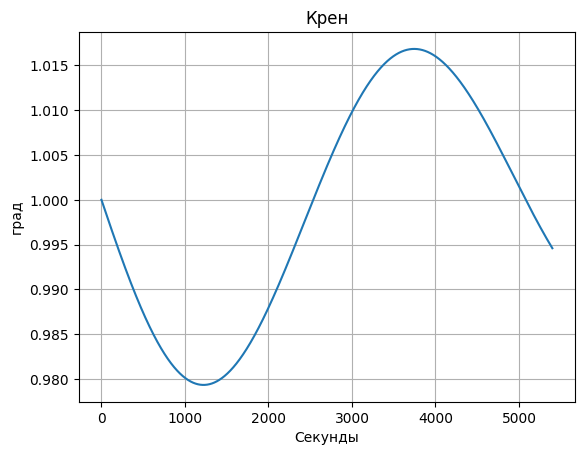

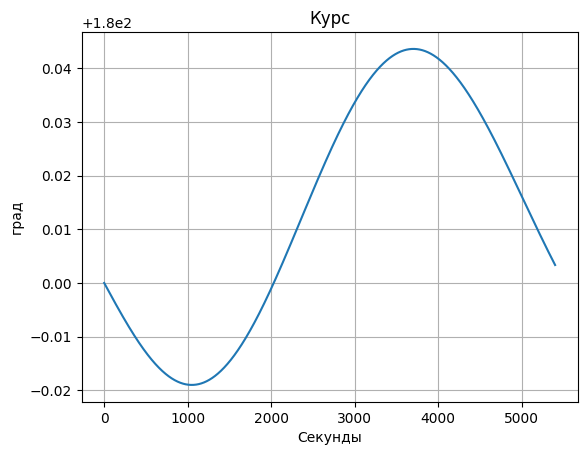

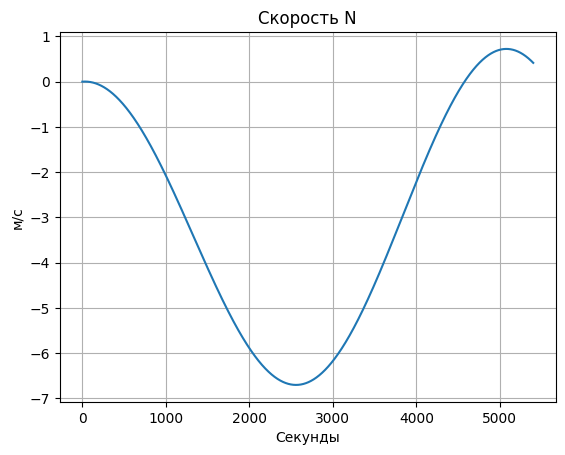

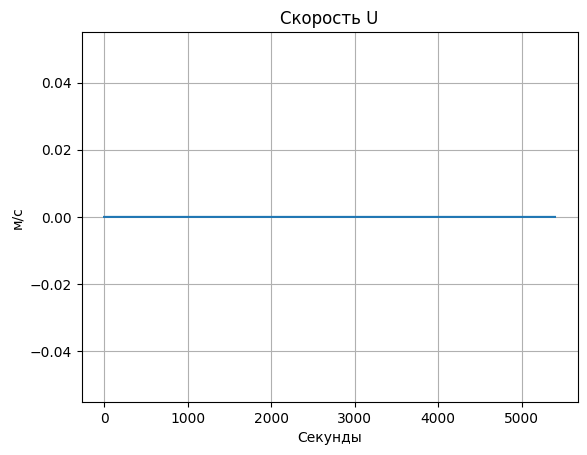

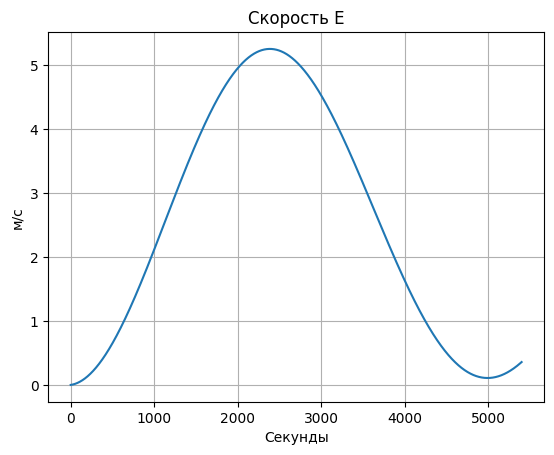

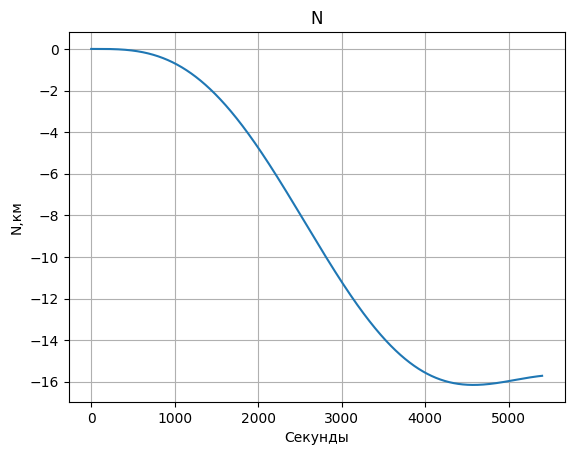

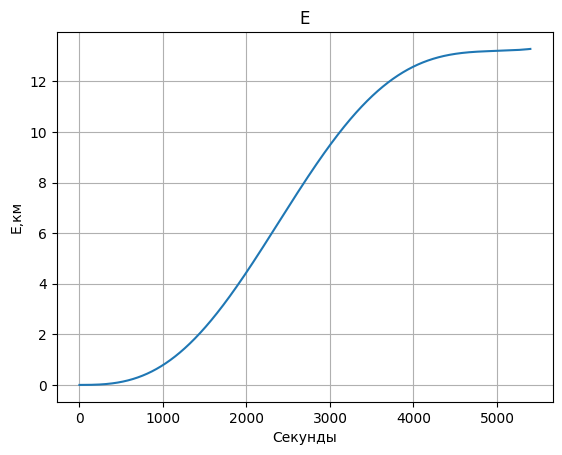

In [9]:
plt.figure(1)
plt.plot(t,queue_Lat)
plt.title("Широта")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(t,queue_Lon)
plt.title("Долгота")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(t,queue_pitch)
plt.title("Тангаж")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(4)
plt.plot(t,queue_roll)
plt.title("Крен")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(5)
plt.plot(t,queue_heading)
plt.title("Курс")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(6)
plt.plot(t,queue_W_N)
plt.title("Скорость N")
plt.xlabel('Cекунды')
plt.ylabel('м/c')
plt.grid(True)
plt.show()

plt.figure(7)
plt.plot(t,queue_W_U)
plt.title("Скорость U")
plt.xlabel('Cекунды')
plt.ylabel('м/c')
plt.grid(True)
plt.show()

plt.figure(8)
plt.plot(t,queue_W_E)
plt.title("Скорость E")
plt.xlabel('Cекунды')
plt.ylabel('м/c')
plt.grid(True)
plt.show()

R = 6356.863 # км
queue_x = (queue_Lat * ((np.pi / 180) * R)) - (queue_Lat[0] * ((np.pi / 180) * R))
queue_y = (queue_Lon * (np.pi / 180) * (R * np.cos(Lat))) - (queue_Lon[0] * np.pi / 180 * (R * np.cos(Lat)))
plt.figure(9)
plt.plot(t,queue_x)
plt.title("N")
plt.xlabel('Cекунды')
plt.ylabel('N,км')
plt.grid(True)
plt.show()

plt.figure(10)
plt.plot(t,queue_y)
plt.title("E")
plt.xlabel('Cекунды')
plt.ylabel('E,км')
plt.grid(True)
plt.show()